<a href="https://colab.research.google.com/github/calamistratus/Rainfall_project/blob/main/Rainfall_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def check_na(dataframe, column = ''): #   Checks for NaNs in dataframe, if the column is provided, gives a more detailed summary
    if column:
        print('\n', dataframe[column].value_counts().head(10), '\n\n', 'Number of na:', dataframe[column].isnull().sum(), '\n')
        return pd.concat([dataframe[dataframe[column].isnull() > 0].head(),
                          dataframe.head(1) == np.nan,
                          dataframe.sample(len(dataframe[dataframe[column].isnull() > 0].head()))], axis=0)
    else:
        return dataframe.isnull().sum()[dataframe.isnull().sum() > 0]

In [203]:
path = ''

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

df = pd.concat([train, test], axis=0, ignore_index=True).set_index('id')

In [204]:
check_na(df)

,0
winddirection,1
rainfall,730


In [205]:
check_na(df, 'winddirection')


 winddirection
70.0     369
220.0    326
20.0     319
40.0     315
50.0     260
80.0     229
60.0     204
230.0    194
30.0      99
200.0     82
Name: count, dtype: int64 

 Number of na: 1 



,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
2707,153,1007.8,32.9,30.6,28.9,22.0,65.0,75.0,8.2,NaN,17.2,NaN
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1817,358,1017.7,20.6,16.8,14.6,12.1,79.0,80.0,2.3,60.0,33.0,1.0


In [206]:
df.loc[2707, 'winddirection'] = df.loc[2706:2708]['winddirection'].mean()  #  Picked an average value between the day before and after

In [209]:
def get_season(day):
  if day < 90:
    return 'winter'
  elif day < 181:
    return 'spring'
  elif day < 275:
    return 'summer'
  else:
    return 'autumn'

df['season'] = df['day'].apply(get_season)

def get_wind_direction(degrees):
  match degrees // 90:
    case 0:
      return 'north'
    case 1:
      return 'east'
    case 2:
      return 'south'
    case _:
      return 'west'

df['windside'] = df['winddirection'].apply(get_wind_direction)

df['temparature_range'] = df['maxtemp'] - df['mintemp']
df['nosunshine'] = df['sunshine'] == 0.0
#  Feature engineering.

In [210]:
df_dum = pd.get_dummies(df, drop_first=True)
df_dum_stat = pd.get_dummies(df)

corr = df_dum_stat.corr()

<Axes: xlabel='rainfall'>

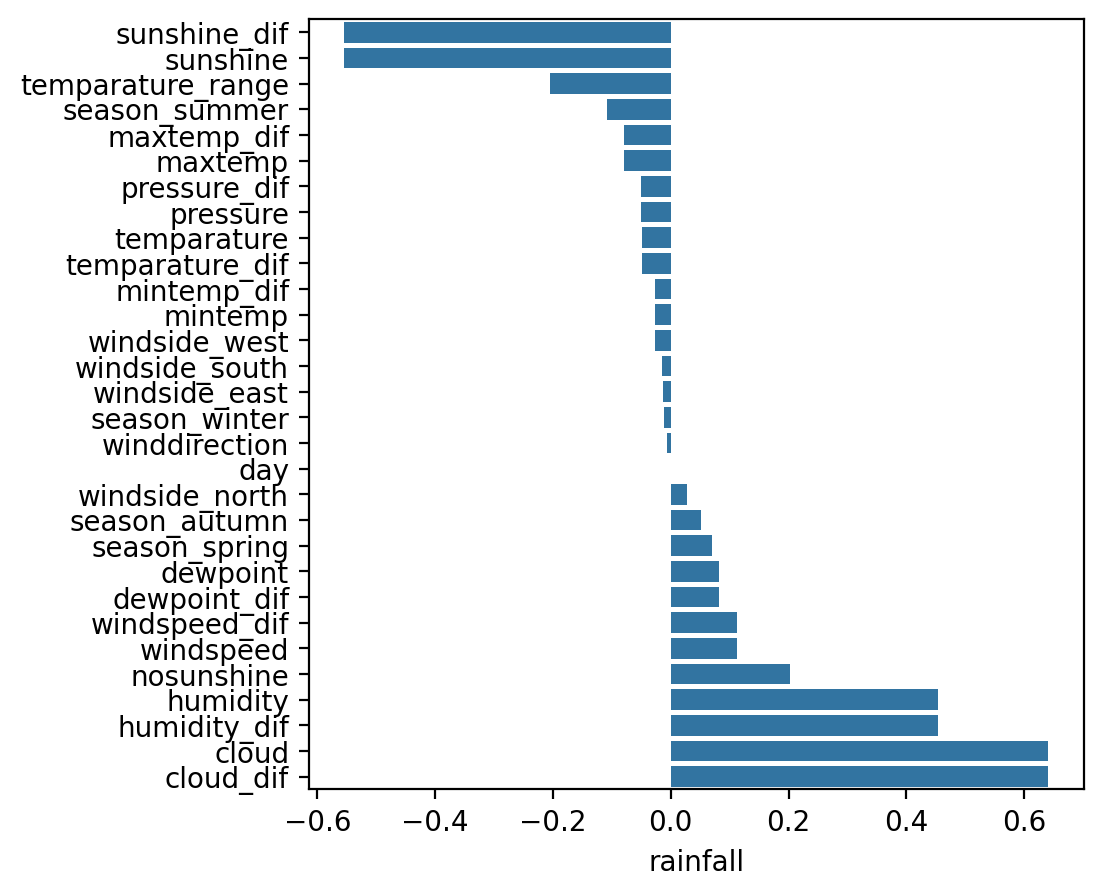

In [211]:
plt.figure(dpi=200, figsize=(5,5))
sns.barplot(corr['rainfall'].sort_values().drop('rainfall'), orient='h')

<Axes: xlabel='season', ylabel='rainfall'>

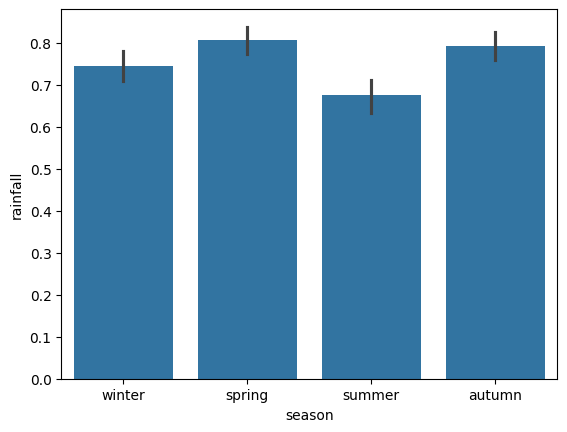

In [12]:
sns.barplot(data=df, x='season', y='rainfall')

<Axes: xlabel='windside', ylabel='rainfall'>

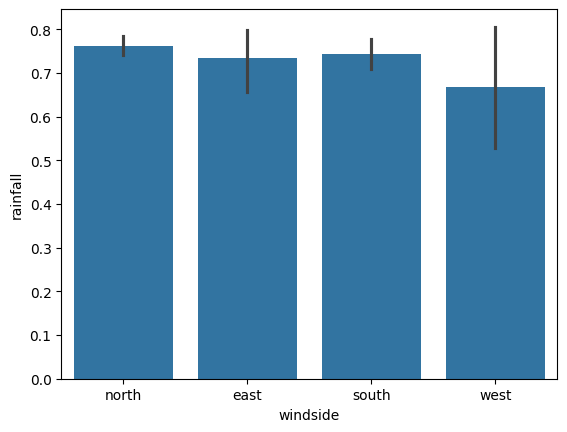

In [13]:
sns.barplot(data=df, x='windside', y='rainfall')

(0.0, 100.0)

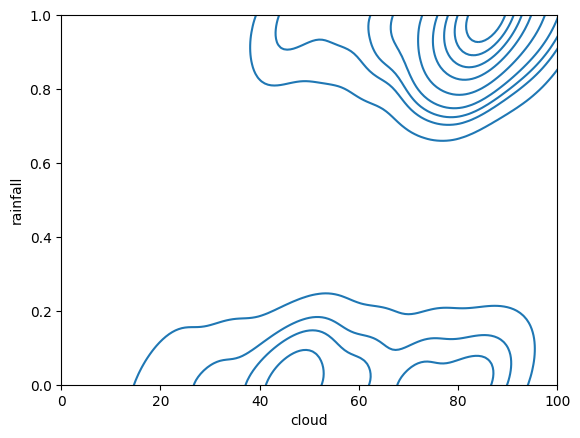

In [14]:
sns.kdeplot(x=df['cloud'], y=df['rainfall'])
plt.ylim(0,1)
plt.xlim(0,100)

<Axes: xlabel='cloud', ylabel='humidity'>

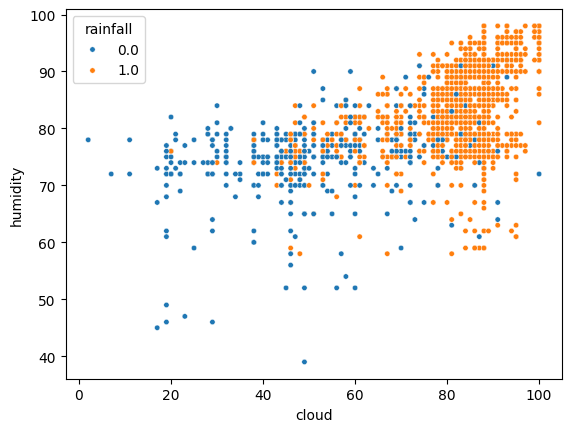

In [15]:
sns.scatterplot(data=df, x='cloud', y='humidity', hue='rainfall', s=15)

<Axes: xlabel='temparature', ylabel='sunshine'>

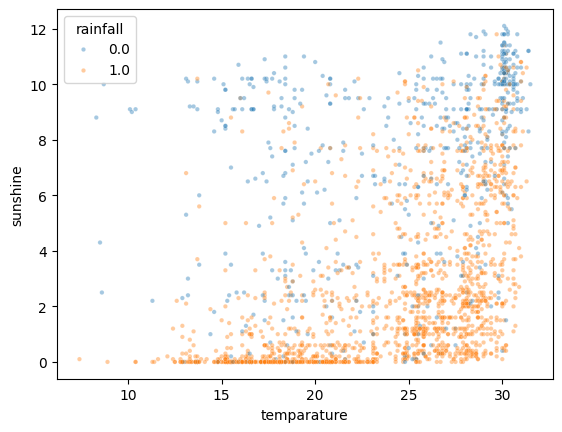

In [16]:
sns.scatterplot(data=df, x='temparature', y='sunshine', hue='rainfall', s=10, alpha=.4)

In [212]:
train_dum = df_dum[~df_dum['rainfall'].isnull()]
test_dum = df_dum[df_dum['rainfall'].isnull()].drop('rainfall', axis=1)

In [213]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures #  Polynomial features were proven to be ineffective with this data
from sklearn.model_selection import train_test_split

X = train_dum.drop('rainfall', axis=1)
y = train_dum['rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler().fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.fit_transform(X)

#poly = PolynomialFeatures().fit(X_train)

#poly_X_train = poly.transform(X_train)
#poly_X_test = poly.transform(X_test)
#poly_X = poly.fit_transform(X)

#poly_scaler = StandardScaler().fit(poly_X_train)

#oly_X_train = poly_scaler.transform(poly_X_train)
#poly_X_test = poly_scaler.transform(poly_X_test)
#poly_X = poly_scaler.fit_transform(poly_X)

scaled_test = scaler.transform(test_dum)
#poly_test = poly_scaler.transform(poly.transform(test_dum))

In [214]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.model_selection import GridSearchCV

#Functions for simple model testing

def test_model(model, sample=None, random_state=42, return_model=False):

  if sample:
    sub_df = pd.DataFrame(scaled_X_train)
    sub_df['goal'] = np.array(y_train)
    sub_df = sub_df.sample(frac=sample, random_state=42)

    model.fit(sub_df.drop('goal', axis=1), sub_df['goal'])
  else:
    model.fit(scaled_X_train, y_train)

  preds = model.predict(scaled_X_test)

  ConfusionMatrixDisplay.from_predictions(y_test, preds)
  RocCurveDisplay.from_predictions(y_test, preds)
  #print(classification_report(y_test, preds))
  if return_model:
    return model

def test_grid(model, param_grid, sample=None, random_state=42, verbose=2, cv=3, return_model=False):
  grid = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, verbose=verbose)

  if sample:
    sub_df = pd.DataFrame(scaled_X_train)
    sub_df['goal'] = np.array(y_train)
    sub_df = sub_df.sample(frac=sample, random_state=random_state)

    grid.fit(sub_df.drop('goal', axis=1), sub_df['goal'])
  else:
    grid.fit(scaled_X_train, y_train)
  preds = grid.predict(scaled_X_test)

  ConfusionMatrixDisplay.from_predictions(y_test, preds)
  RocCurveDisplay.from_predictions(y_test, preds)
  #print(classification_report(y_test, preds))
  print(grid.best_params_)
  if return_model:
    return grid

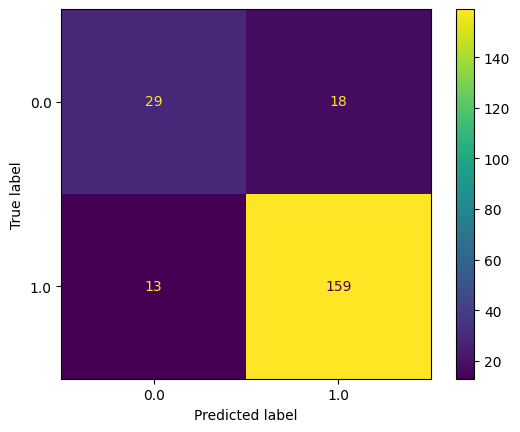

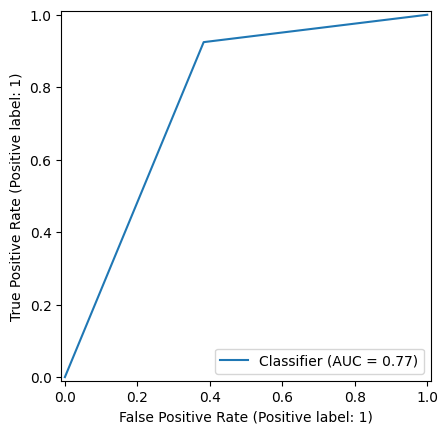

In [ ]:
from xgboost import XGBRFClassifier

test_model(XGBRFClassifier())  #  XGboost models did not work for me at this task.

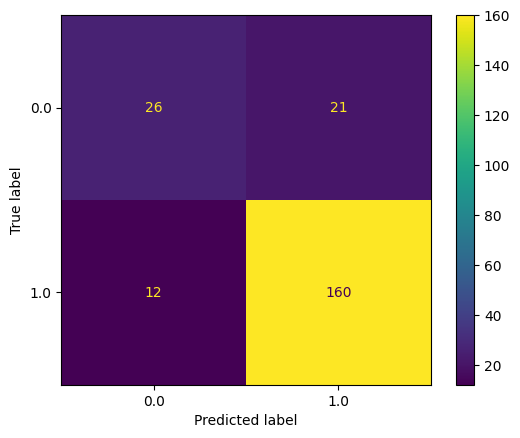

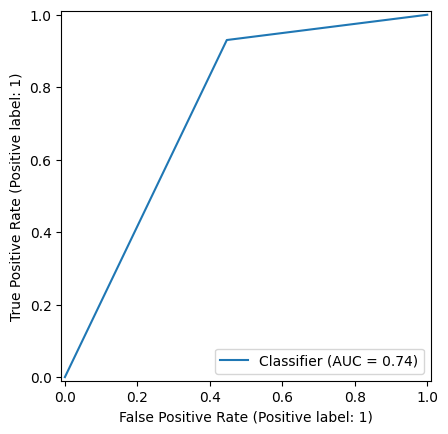

In [ ]:
from xgboost import XGBClassifier

test_model(XGBClassifier())

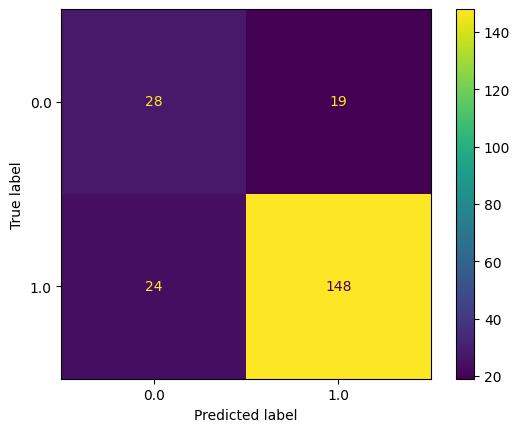

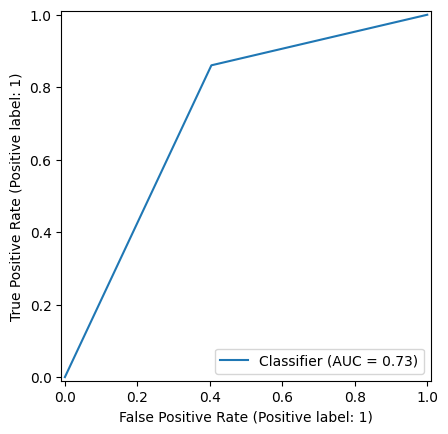

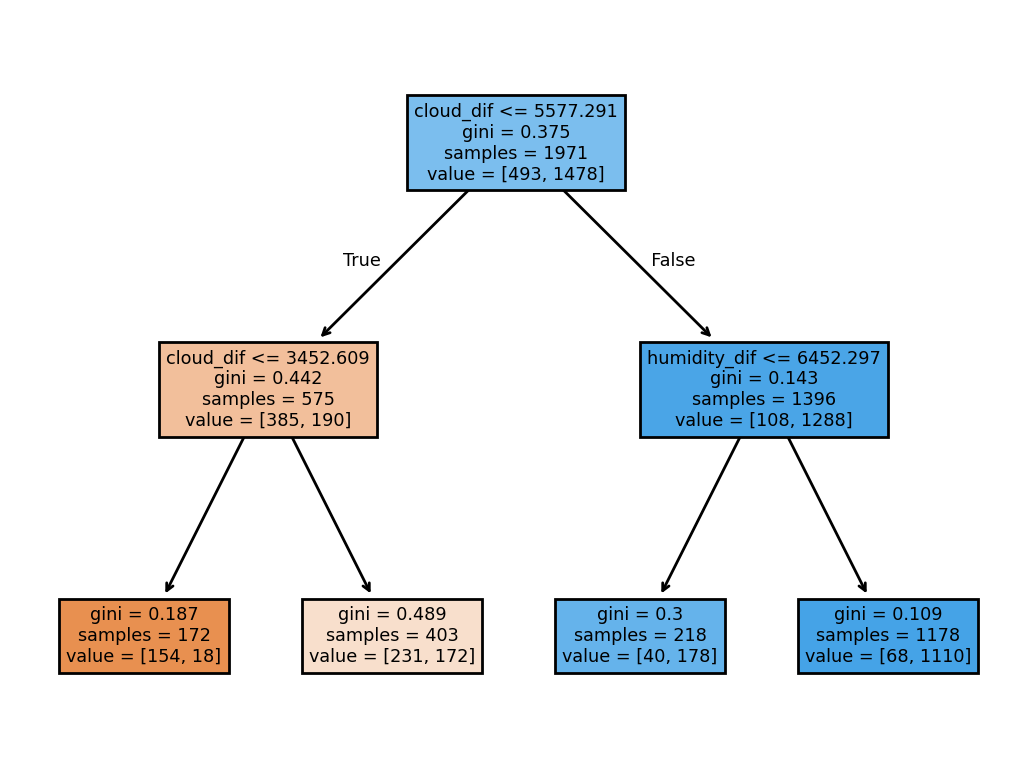

In [225]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

test_model(DecisionTreeClassifier());  #  Performs bad alone.

plt.figure(dpi=200)
plot_tree(DecisionTreeClassifier(max_depth=2).fit(X_train, y_train), filled=True, feature_names=X_train.columns);

1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 

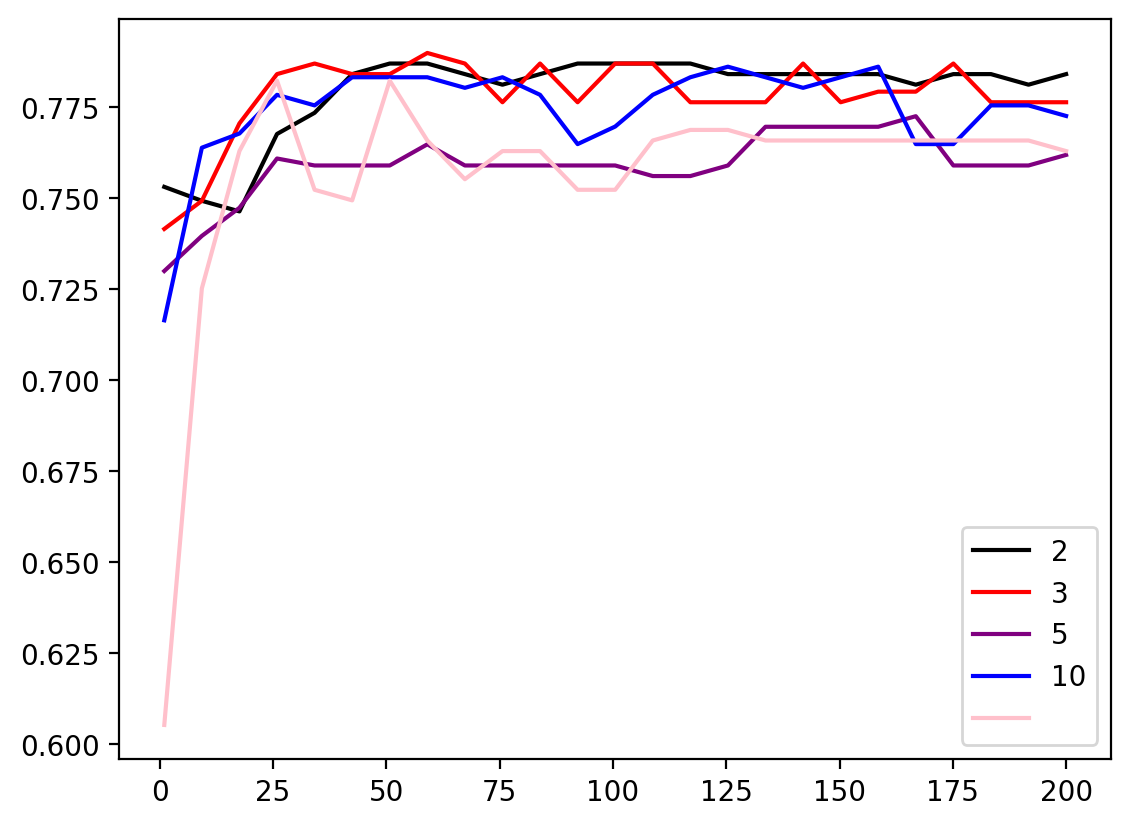

In [197]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

errors = []
range = np.linspace(1, 200, 25)
c = -1
colors = ['black', 'red', 'purple', 'blue', 'pink']
plt.figure(dpi=200)

for j in [2, 3, 5, 10, None]:
  errors = []
  c += 1
  for i in range:
    print(round(i), end=' / ')
    rfc = RandomForestClassifier(n_estimators=round(i), max_depth=j, class_weight='balanced', random_state=42).fit(scaled_X_train, y_train)
    preds = rfc.predict(scaled_X_test)

    errors.append(roc_auc_score(y_test, preds))
  plt.plot(range, errors, color=colors[c])

plt.legend([2, 3, 5, 10, None])
plt.show()  #  Not good enough to use it.

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'criterion': 'gini', 'min_impurity_decrease': 0, 'min_weight_fraction_leaf': 0}


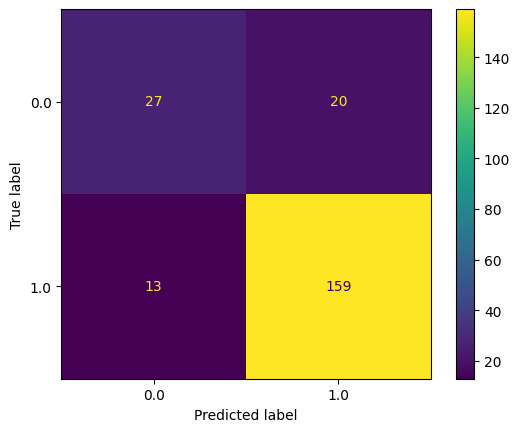

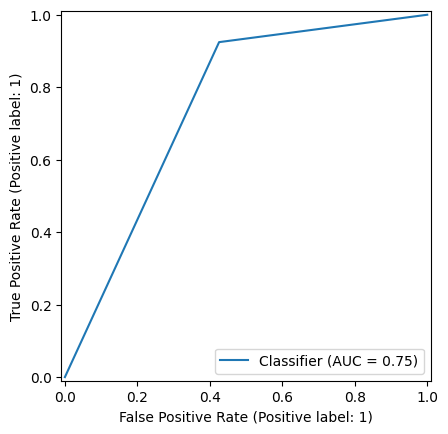

In [ ]:
test_grid(RandomForestClassifier(n_estimators=60, class_weight='balanced', max_features=3, random_state=42),
          {'criterion' : ['gini', 'entropy', 'log_loss'],
           'min_weight_fraction_leaf' : [0, .01, .1, .5],
           'min_impurity_decrease' : [0, .01, .1, .5]},
          verbose=1,
          cv=3)  #  Surprisingly defaults work the best.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}


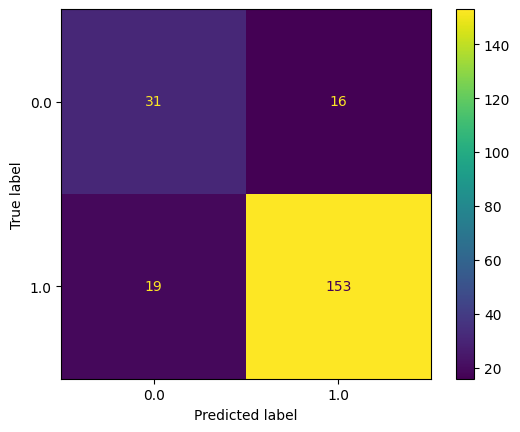

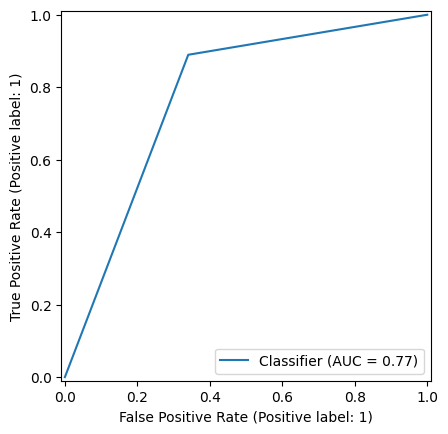

In [ ]:
from sklearn.svm import SVC

test_grid(SVC(class_weight='balanced'), {'kernel' : ['rbf', 'sigmoid', 'linear', 'poly'],
                  'C' : [.01, .1, 1, 10, 100],
                  'gamma' : ['scale', 'auto']},
                  verbose=1,
                  cv=5)  #  Just doesn't work and overtunes rapidly.

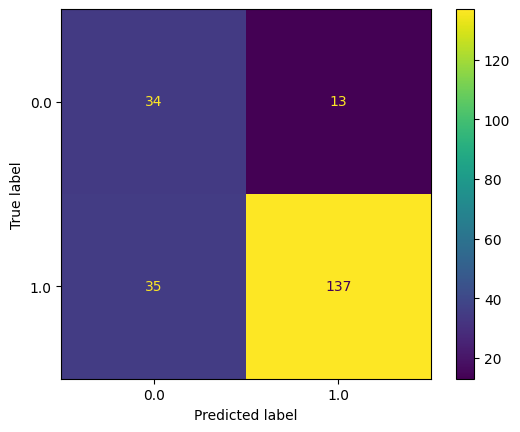

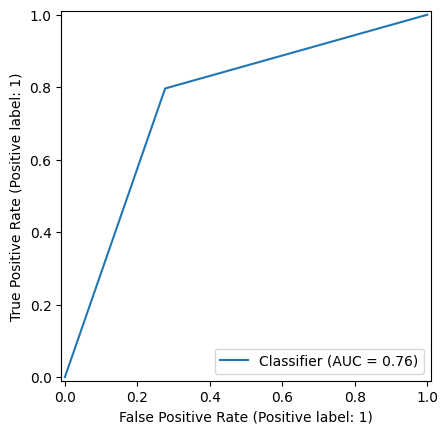

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler().fit(X_train)
mm_X_train = mmscaler.transform(X_train)
mm_X_test = mmscaler.transform(X_test)

gnb = GaussianNB().fit(mm_X_train, y_train)

preds = gnb.predict(mm_X_test)

ConfusionMatrixDisplay.from_predictions(y_test, preds)
RocCurveDisplay.from_predictions(y_test, preds)  #  Abscure.

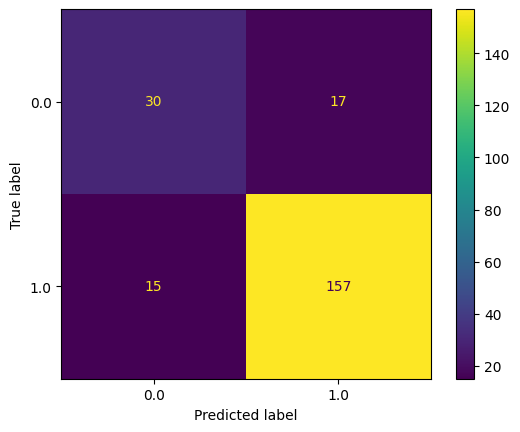

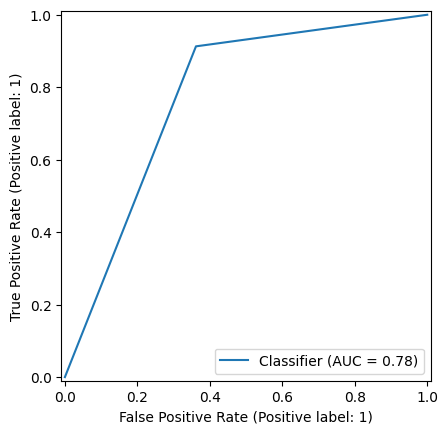

In [69]:
from sklearn.neighbors import KNeighborsClassifier

test_model(KNeighborsClassifier(12))  #  Simplest predictor

1 / 3 / 5 / 7 / 9 / 11 / 13 / 15 / 17 / 19 / 21 / 23 / 25 / 27 / 29 / 31 / 33 / 35 / 37 / 39 / 41 / 43 / 45 / 47 / 49 / 52 / 54 / 56 / 58 / 60 / 62 / 64 / 66 / 68 / 70 / 72 / 74 / 76 / 78 / 80 / 82 / 84 / 86 / 88 / 90 / 92 / 94 / 96 / 98 / 100 / 1 / 3 / 5 / 7 / 9 / 11 / 13 / 15 / 17 / 19 / 21 / 23 / 25 / 27 / 29 / 31 / 33 / 35 / 37 / 39 / 41 / 43 / 45 / 47 / 49 / 52 / 54 / 56 / 58 / 60 / 62 / 64 / 66 / 68 / 70 / 72 / 74 / 76 / 78 / 80 / 82 / 84 / 86 / 88 / 90 / 92 / 94 / 96 / 98 / 100 / 

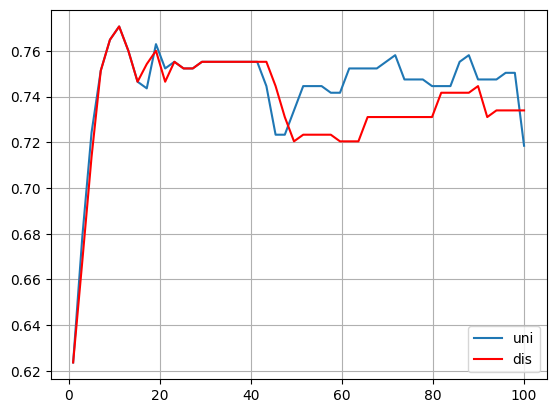

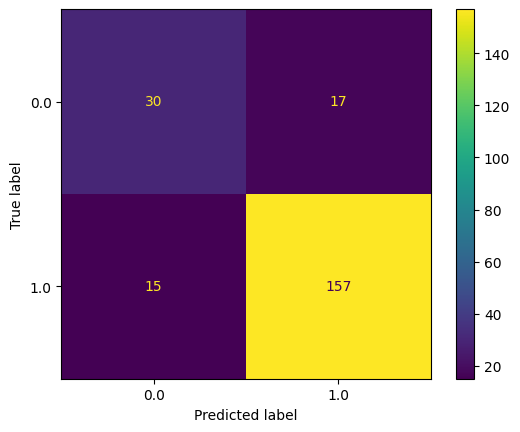

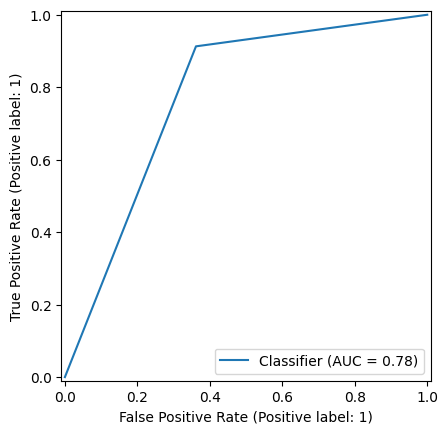

In [198]:
from sklearn.metrics import roc_auc_score

errors = []
range = np.linspace(1, 100, 50)

for i in range:
  print(round(i), end=' / ')
  knn = KNeighborsClassifier(round(i)).fit(scaled_X_train, y_train)
  preds = knn.predict(scaled_X_test)

  errors.append(roc_auc_score(y_test, preds))

plt.plot(range, errors)

errors = []

for i in range:
  print(round(i), end=' / ')
  knn = KNeighborsClassifier(round(i), weights='distance').fit(scaled_X_train, y_train)
  preds = knn.predict(scaled_X_test)

  errors.append(roc_auc_score(y_test, preds))

plt.plot(range, errors, color='r')
plt.grid(True)
plt.legend(['uni', 'dis'])
plt.show()
test_model(KNeighborsClassifier(12))  #  Value of 15-20 isn't too bad overall, but is still lacking. Simple and effective though.

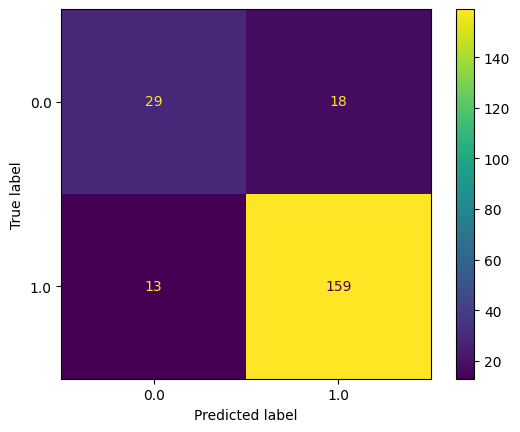

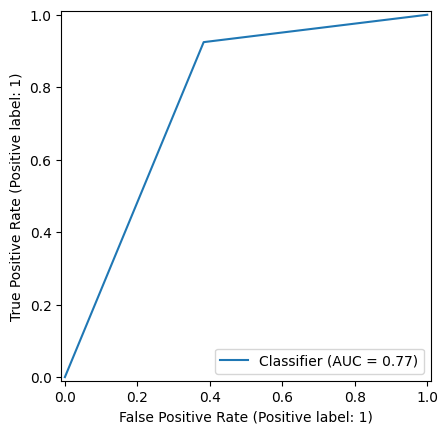

In [29]:
from sklearn.linear_model import LogisticRegression

test_model(LogisticRegression())  #  Greate result for a linear model.

1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 20 / 21 / 22 / 23 / 24 / 25 / 26 / 27 / 28 / 29 / 

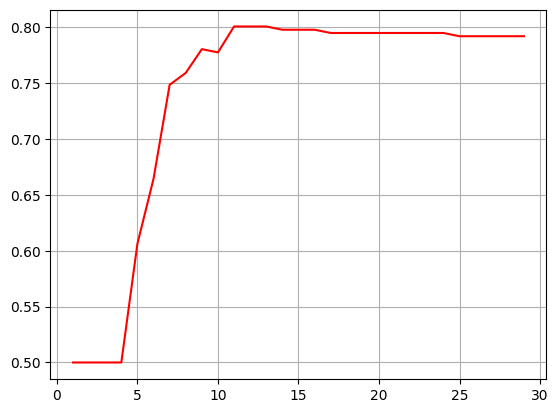

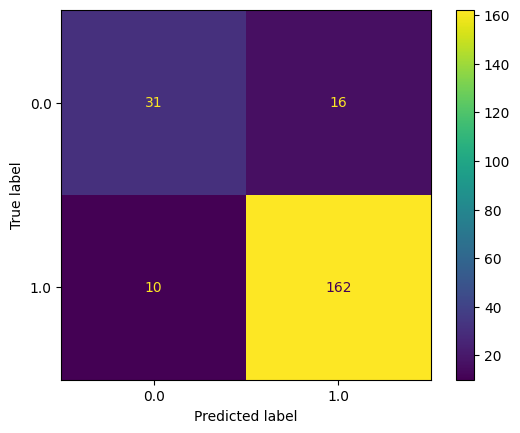

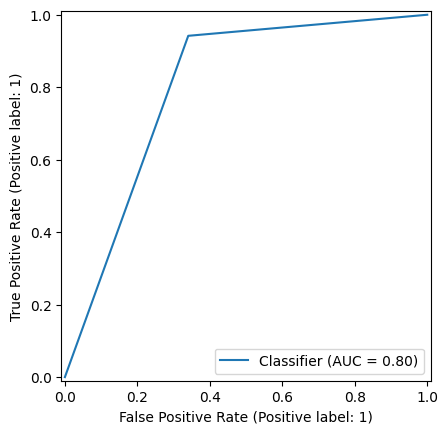

In [186]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

errors = []
nrange = list(range(1, 30))

for i in nrange:
  print(round(i), end=' / ')
  gbc = GradientBoostingClassifier(n_estimators = round(i)).fit(scaled_X_train, y_train)
  preds = gbc.predict(scaled_X_test)

  errors.append(roc_auc_score(y_test, preds))

plt.plot(nrange, errors, color='r')
plt.grid(True)
#plt.ylim(0.775, 0.825)
plt.show()

test_model(GradientBoostingClassifier(n_estimators=12))  #  A simple GradientBosstingClassifier which performs decently.

1 / 13 / 26 / 38 / 50 / 1 / 13 / 26 / 38 / 50 / 1 / 13 / 26 / 38 / 50 / 1 / 13 / 26 / 38 / 50 / 

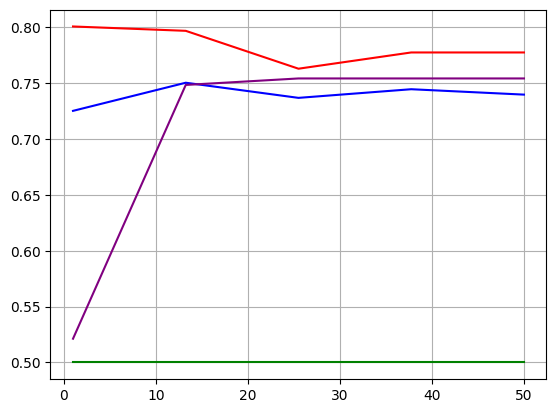

In [202]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

nrange = np.linspace(1, 50, 5)

for j in [[GradientBoostingClassifier(n_estimators=12), 'red'], [DecisionTreeClassifier(), 'blue'], [LogisticRegression(), 'purple'], [SVC(), 'green']]:
  errors = []
  for i in nrange:
    print(round(i), end=' / ')
    ada = AdaBoostClassifier(j[0], n_estimators = round(i)).fit(scaled_X_train, y_train)
    preds = ada.predict(scaled_X_test)

    errors.append(roc_auc_score(y_test, preds))
  plt.plot(nrange, errors, color=j[1])

plt.grid(True)
plt.show()  #  Doesn't seem to be working with any model I tried.

1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 20 / 21 / 22 / 23 / 24 / 25 / 26 / 27 / 28 / 29 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 20 / 21 / 22 / 23 / 24 / 25 / 26 / 27 / 28 / 29 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 20 / 21 / 22 / 23 / 24 / 25 / 26 / 27 / 28 / 29 / 

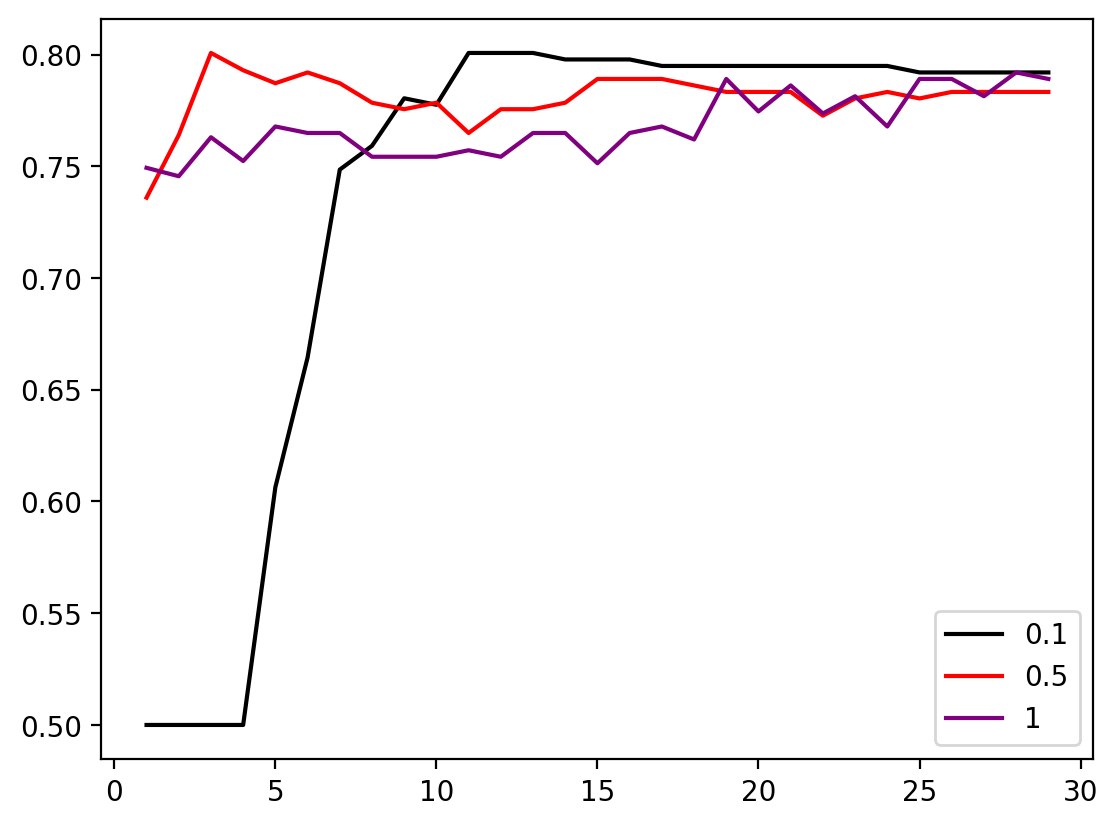

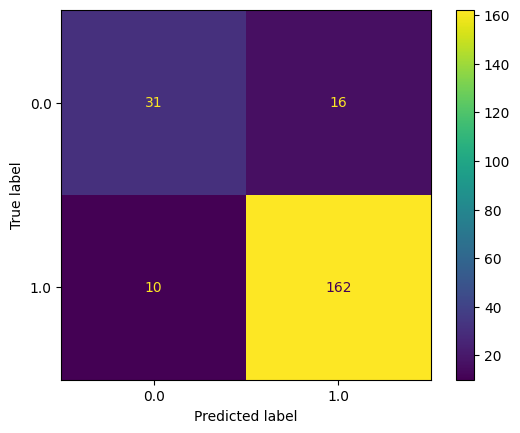

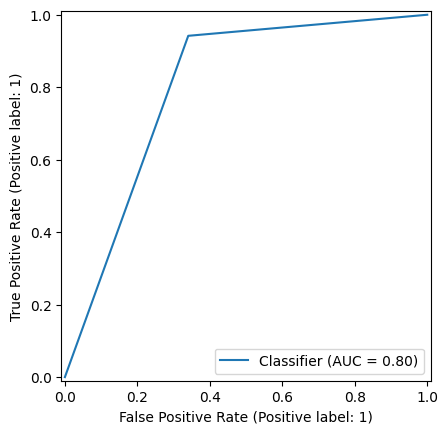

In [192]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

errors = []
nrange = list(range(1, 30))
c = -1
colors = ['black', 'red', 'purple', 'blue', 'pink']
param_list = [.1, .5, 1]
plt.figure(dpi=200)

for j in param_list:
  errors = []
  c += 1
  for i in nrange:
    print(round(i), end=' / ')
    gbc = GradientBoostingClassifier(n_estimators=round(i), verbose=0,  learning_rate=j).fit(scaled_X_train, y_train)
    preds = gbc.predict(scaled_X_test)

    errors.append(roc_auc_score(y_test, preds))
  plt.plot(nrange, errors, color=colors[c])

plt.legend(param_list)
plt.show()

test_model(GradientBoostingClassifier(n_estimators=3, learning_rate=.5))  #  Works even better than the one tuned less.

1 / 3 / 5 / 7 / 9 / 11 / 13 / 15 / 17 / 19 / 22 / 24 / 26 / 28 / 30 / 32 / 34 / 36 / 38 / 40 / 1 / 3 / 5 / 7 / 9 / 11 / 13 / 15 / 17 / 19 / 22 / 24 / 26 / 28 / 30 / 32 / 34 / 36 / 38 / 40 / 1 / 3 / 5 / 7 / 9 / 11 / 13 / 15 / 17 / 19 / 22 / 24 / 26 / 28 / 30 / 32 / 34 / 36 / 38 / 40 / 1 / 3 / 5 / 7 / 9 / 11 / 13 / 15 / 17 / 19 / 22 / 24 / 26 / 28 / 30 / 32 / 34 / 36 / 38 / 40 / 1 / 3 / 5 / 7 / 9 / 11 / 13 / 15 / 17 / 19 / 22 / 24 / 26 / 28 / 30 / 32 / 34 / 36 / 38 / 40 / 

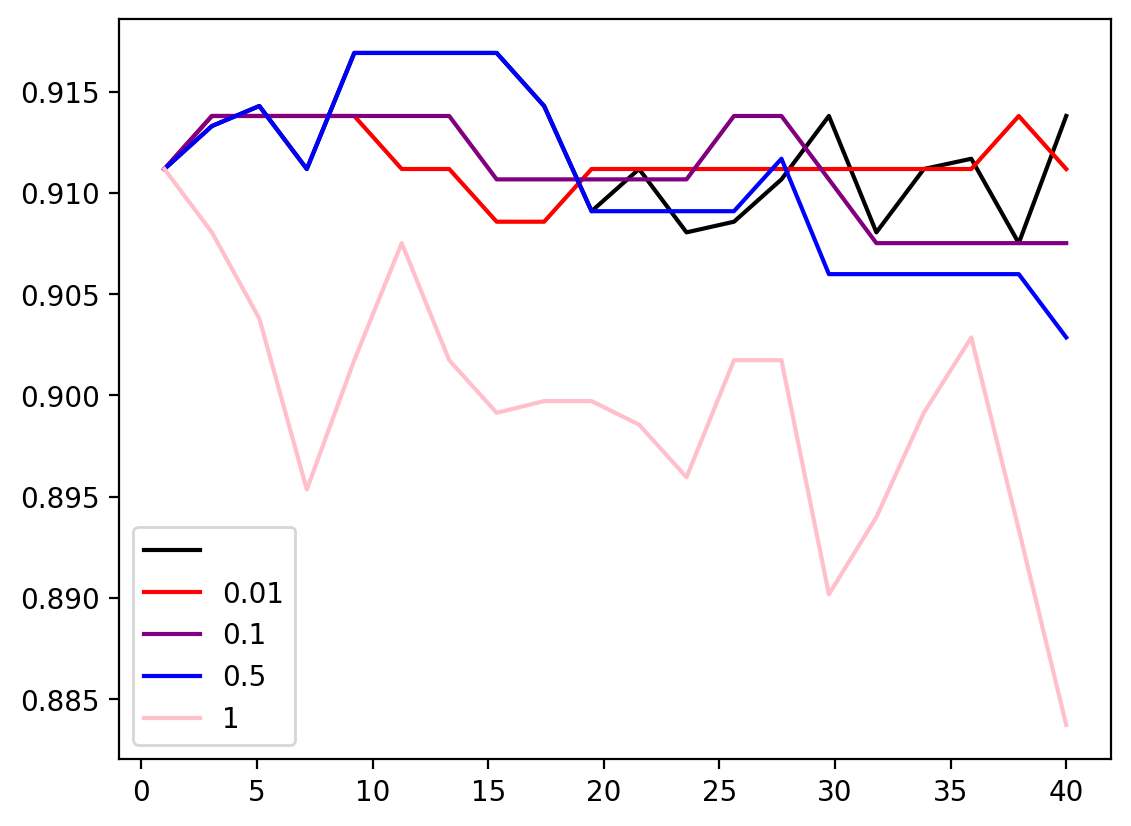

In [105]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score  #  ROC works poorly with CatBoost, so I had to resort to the F1 scoring.

errors = []
nrange = np.linspace(1, 40, 20)
c = -1
colors = ['black', 'red', 'purple', 'blue', 'pink']
param_list = [None, .01, .1, .5, 1]
plt.figure(dpi=200)

for j in param_list:
  errors = []
  c += 1
  for i in nrange:
    print(round(i), end=' / ')
    cat = CatBoostClassifier(n_estimators=round(i), verbose=0,  learning_rate=j).fit(scaled_X_train, y_train)
    preds = cat.predict(scaled_X_test)

    errors.append(f1_score(y_test, preds))
  plt.plot(range, errors, color=colors[c])

plt.legend(param_list)
plt.show()  #  Picking the best learning rate for the CatBoost.

1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 

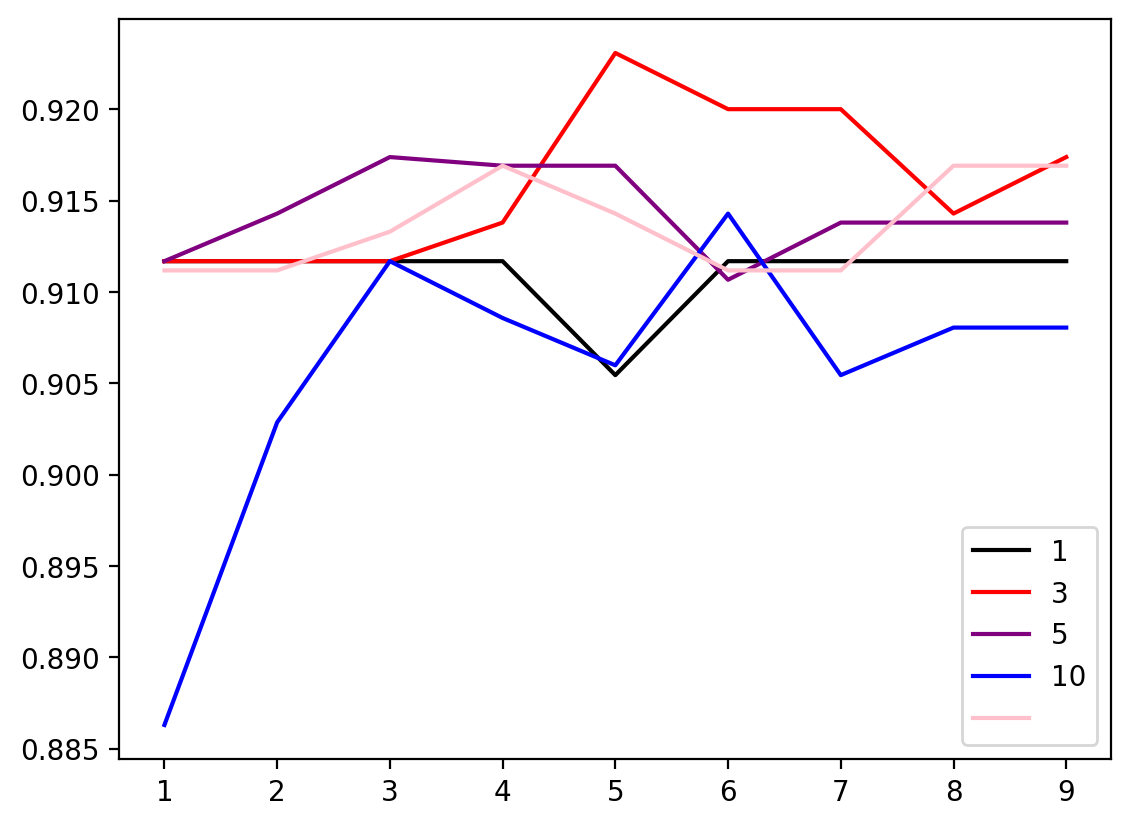

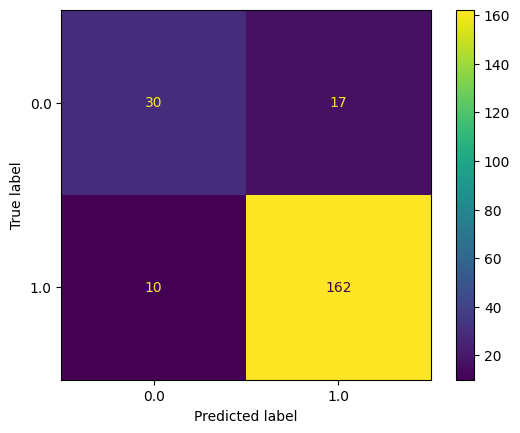

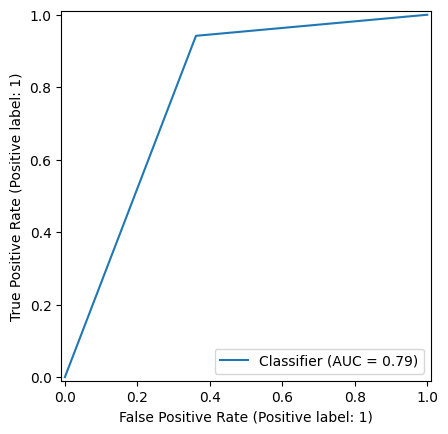

In [137]:
errors = []
nrange = range(1, 10)
c = -1
colors = ['black', 'red', 'purple', 'blue', 'pink']
param_list = [1, 3, 5, 10, None]
plt.figure(dpi=200)

for j in param_list:
  errors = []
  c += 1
  for i in nrange:
    print(round(i), end=' / ')
    cat = CatBoostClassifier(n_estimators=round(i), verbose=0, learning_rate=.5, depth=j).fit(scaled_X_train, y_train)
    preds = cat.predict(scaled_X_test)

    errors.append(f1_score(y_test, preds))
  plt.plot(nrange, errors, color=colors[c])

plt.legend(param_list)
plt.show()

test_model(CatBoostClassifier(n_estimators=5, learning_rate=.5, depth=3, verbose=0))  #  Works great after some tuning.

0:	learn: 0.4965641	total: 3.92ms	remaining: 15.7ms
1:	learn: 0.4141897	total: 5.3ms	remaining: 7.95ms
2:	learn: 0.3819645	total: 11.8ms	remaining: 7.89ms
3:	learn: 0.3541296	total: 13.2ms	remaining: 3.29ms
4:	learn: 0.3461079	total: 19.4ms	remaining: 0us


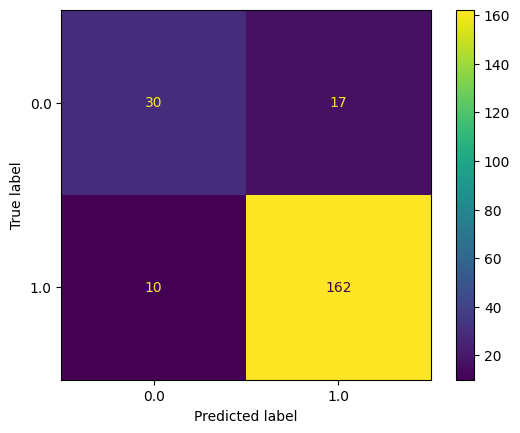

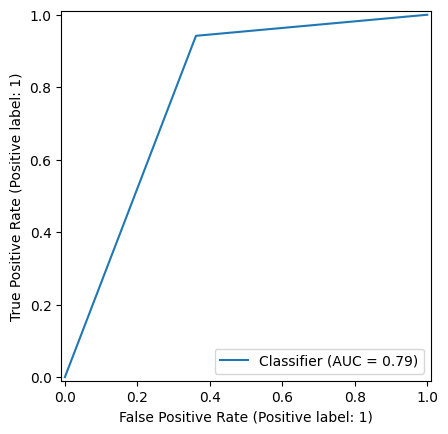

In [183]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([('gbc', GradientBoostingClassifier(n_estimators=12)),
                       ('gbc2', GradientBoostingClassifier(n_estimators=3, learning_rate=.5)),
                       ('knn', KNeighborsClassifier(12)),
                       ('cat', CatBoostClassifier(n_estimators=5, learning_rate=.5, depth=3))],
                       voting='soft')

test_model(vc)  #  Works the best, even though it took a lot of tuning cherrypicking the right models.

In [184]:
best = vc.fit(scaled_X, y)  #  Model seems to perform better training of a scaled_X_train dataframe, which is quite strange. For the sake of eliminating varience I sacrificed 0.00145 of the private score.
preds = best.predict_proba(scaled_test)  #  The final score is 0.89564, or 0.89709 with the previous line deleted.

sub = pd.DataFrame([np.array(test_dum.index), preds]).transpose()
sub = pd.DataFrame({ 'id': test_dum.index.astype(int), 'rainfall': preds[:, 1]})
sub = sub.set_index('id')

sub.to_csv('rainfall_sub.csv')